In [1]:
#| echo: false
import seaborn as sns
import random
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import plotly.io as pio
import plotly.graph_objects as go
import numpy as np
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import imageio
import os
import imageio.v2 as imageio  # Option 1: Import ImageIO version 2 explicitly
from math import exp

Life is full of solving problems. We are constantly searching for solutions, and in Artificial Intelligence there's a whole subfield about search algorithms. In this article, I want to introduce the algorithm which fascinates me the most.

## The problem

Search Problems are difficult to solve. But why is that? Essentially, it is because the things we hope to find are a lot less common than the things we do not want to find. Take, for example, a Rubik's cube: It has 43 quintillion configurations, out of only 1 is the correct one. If we were to approach this problem without a strategy, the chances are 1:43 quintillion of finding the solution every time we make a turn. Entropy can be defined as the number of states that a system can have^[this definition is simplistic and applies more specifically to the context of statistical mechanics]. So in the example of the Rubik's cube, it is low when we only consider a "solved" Rubik's cube, but high when we consider an "unsolved" Rubik's cube. Together with the fact that over time, entropy tends to a maximum^[The second law of thermodynamics], it's the reason that making random turns on the Rubik's cube most likely will leave it in a worse state.

![Simplified overview over the problem: There are many "bad" states for the Rubik's cube and only one "solved" state (red). The chances of picking it are really low.](./states.png)


It almost seems like most of our real-world problems exist because we want order (low entropy) while the world tends to move toward chaos (high entropy). If we could reverse these laws, even if it's just for a moment, we could solve so many problems without any effort. If you had a button to inverse Entropy in our example, you could solve the Rubik's cube by throwing it down the stairs.

Simulated annealing is a search algorithm that was inspired by the annealing process in physics, which in fact leverages Entropy to solve problems. But how does it do it? Increasing entropy, by its very definition, is just a consequence of probabilities. So to understand the magic, we have to look at the world from a statistical perspective because if we can change the probabilities, we can make Entropy work for - and not against us.

## Setup

Before we try to understand how simulated annealing works, I want to simplify the problem and the tools we use to make it more approachable. When working with informed search algorithms like simulated annealing, you are working with the algorithm itself, which is a function, and also a heuristic (or cost) function. The cost function tells you how far away from your goal you are - not more, not less. It doesn't say how to get closer, just how bad the current state is. And because it says how close we are to the goal, minimizing it is our main goal.

Because the Rubik's cube is such a complicated example, let's choose a simpler problem for now. Let's just assume that our cost function is $f(x) = x^{2} + 10 * sin(x)+ 15$^[This function has been randomly chosen and includes a local and global minimum]. From now on, we want to minimize the output of this cost function and therefore find a solution for $x$ that makes $f(x)$ as small as possible, ideally $0$. We can plot how our cost function looks like:

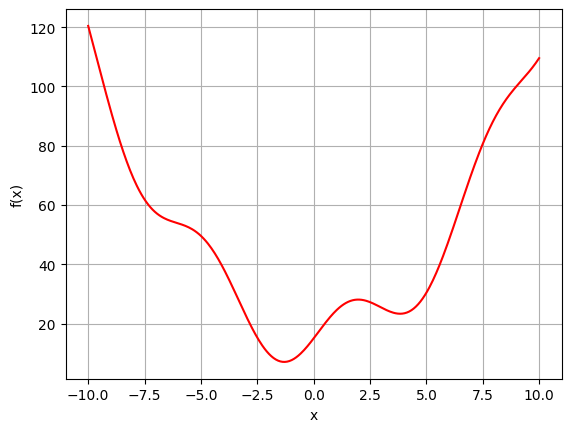

In [2]:
#| echo: false
#| label: fig-f-of-x
#| fig-cap: "$f(x) = x^{2} + 10 * sin(x)+ 15$ (plotted from -10 to 10)"
import numpy as np
import matplotlib.pyplot as plt

# Define the function
def f(x):
    return x**2 + 10 * np.sin(x) + 15

x = np.linspace(-10, 10, 400)
y = f(x)

plt.plot(x, y, 'r')
plt.xlabel("x")
plt.ylabel("f(x)")
plt.grid(True)
plt.show()

## Building a strategy

### Random

To solve this problem and to understand how simulated annealing does it so well, we should look at it from a statistical perspective. Perhaps the simplest approach to finding a solution is to pick a value randomly. How high would the probability of finding the global minimum at around -1.5 be? We can visualize this strategy using a probability density function (PDF).

In [3]:
def algorithm_a(f, iterations):
  x_values = []
  y_values = []
  for t in range(iterations):
    x_values.append(random.uniform(-20, 20)) # <1>
    y_values.append(f(x_values[t]))

  return x_values, y_values

1. At each timestep we just select a random $x$ for our function

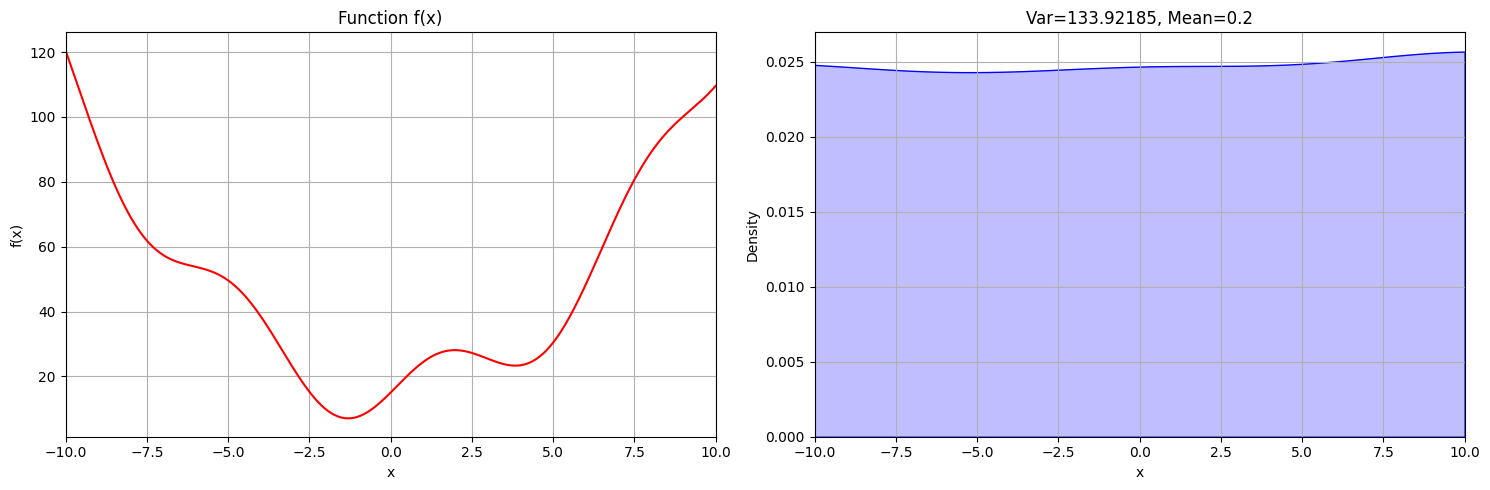

In [4]:
#| echo: false
#| label: fig-PDF-random
#| fig-cap: "Probability density function for the 'random' strategy"
x_values_random, y_values_random = algorithm_a(f, 10000)

# Create a figure with two subplots arranged side by side
fig, axs = plt.subplots(1, 2, figsize=(15, 5))  # Adjusted to a 1x2 grid

# Plot the function on the first subplot
x = np.linspace(-10, 10, 400)
y = f(x)
axs[0].plot(x, y, 'r', label='Function f(x)')
axs[0].set_title('Function f(x)')
axs[0].set_xlabel('x')
axs[0].set_ylabel('f(x)')
axs[0].set_xlim([-10, 10])
axs[0].grid(True)

# Plot the PDF of the search process on the second subplot
sns.kdeplot(x_values_random, ax=axs[1], clip=[-10, 10], fill=True, bw_method=0.3, color='blue', label='PDF of x values')
axs[1].set_title(f'Var={np.var(x_values_random):.5f}, Mean={np.mean(x_values_random):.1f}')
axs[1].set_xlabel('x')
axs[1].set_ylabel('Density')
axs[1].grid(True)
axs[1].set_xlim([-10, 10])

# Adjust the layout
plt.tight_layout()
plt.show()


As you can see, all values of x are equally likely to be picked as the solution, which is of course wrong. Ideally, we want our algorithm to find the solution more often than the wrong answers.

### Preference {#sec-b}

To find the ideal solution more reliably, we could define our algorithm in a way, that it's more likely that a cost-improvement will be accepted rather than a regression. The simplest way would be to accept worse solutions only sometimes, say 50% of the time:

In [5]:
def algorithm_b(f, iterations, initial_x):
  x_values = [initial_x]
  y_values = [f(initial_x)]

  for t in range(iterations):
    current_x, current_y = x_values[len(x_values)-1], y_values[len(y_values)-1]
    new_x = random.uniform(-20, 20)
    new_y = f(new_x)
    if new_y < current_y or random.random() < 0.50: # <1>
      x_values.append(new_x)
      y_values.append(new_y)

  return x_values, y_values

1. Only accept "worse" solutions 50% of the time

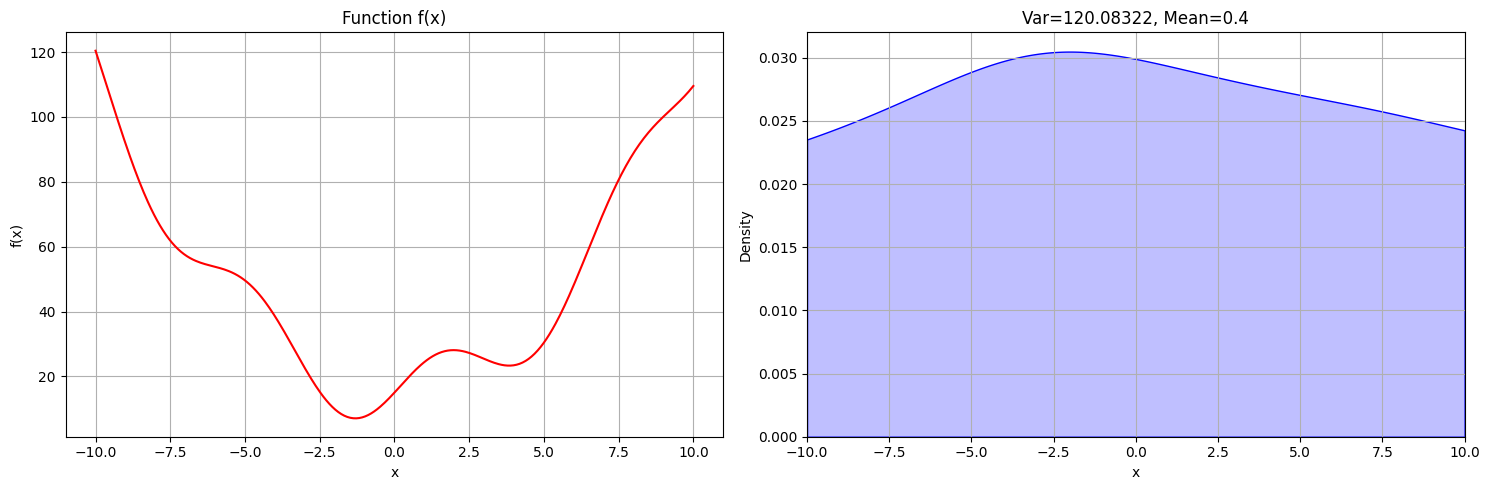

In [6]:
#| echo: false
#| label: fig-PDF-preference
#| fig-cap: "Probability density function for the 'preference' strategy"
x_values_random, y_values_random = algorithm_b(f, 1000, np.random.uniform(-20, 20))

# Create a figure with two subplots
fig, axs = plt.subplots(1,2, figsize=(15, 5))

# Plot the function on the first subplot
x = np.linspace(-10, 10, 400)
y = f(x)
axs[0].plot(x, y, 'r', label='Function f(x)')
axs[0].set_title('Function f(x)')
axs[0].set_xlabel('x')
axs[0].set_ylabel('f(x)')
axs[1].set_xlim([-10, 10])
axs[0].grid(True)

# Plot the PDF of the search process on the second subplot
sns.kdeplot(x_values_random, ax=axs[1], clip=[-10, 10], fill=True, bw_method=0.3, color='blue', label='PDF of x values')
axs[1].set_title(f'Var={np.var(x_values_random):.5f}, Mean={np.mean(x_values_random):.1f}')
axs[1].set_xlabel('x')
axs[1].set_ylabel('Density')
axs[1].grid(True)
axs[1].set_xlim([-10, 10])

# Adjust the layout
plt.tight_layout()
plt.show()


It looks like this strategy helped the algorithm to identify the global minimum more reliably, but it's still yielding many wrong results.

### Neighbors {#sec-c}

The current implementation is inefficient because the progress we made at identifying the best solution will be reset on every time step. Imagine trying to solve a Rubik's cube, but instead of slowly building up your solution, you choose an entirely new configuration every time you make a turn, instead of improving the current one. So instead of choosing an entirely new solution every time we make a move, let's only consider neighboring solutions, that is solutions within a certain interval of the current one. Only considering neighboring states is one important concept that simulated annealing employs.

In [7]:
def algorithm_c(f, iterations, initial_x, p):
  x_values = [initial_x]
  y_values = [f(initial_x)]

  for t in range(iterations):
    current_x, current_y = x_values[len(x_values)-1], y_values[len(y_values)-1]
    new_x = x_values[len(x_values)-1] + random.uniform(-1, 1) # <1>
    new_y = f(new_x)
    if new_y < current_y or random.random() < p:
      x_values.append(new_x)
      y_values.append(new_y)

  return x_values, y_values

1. Only consider neighbouring values of the current states by reducing the interval that we sample from to $[-1, 1]$

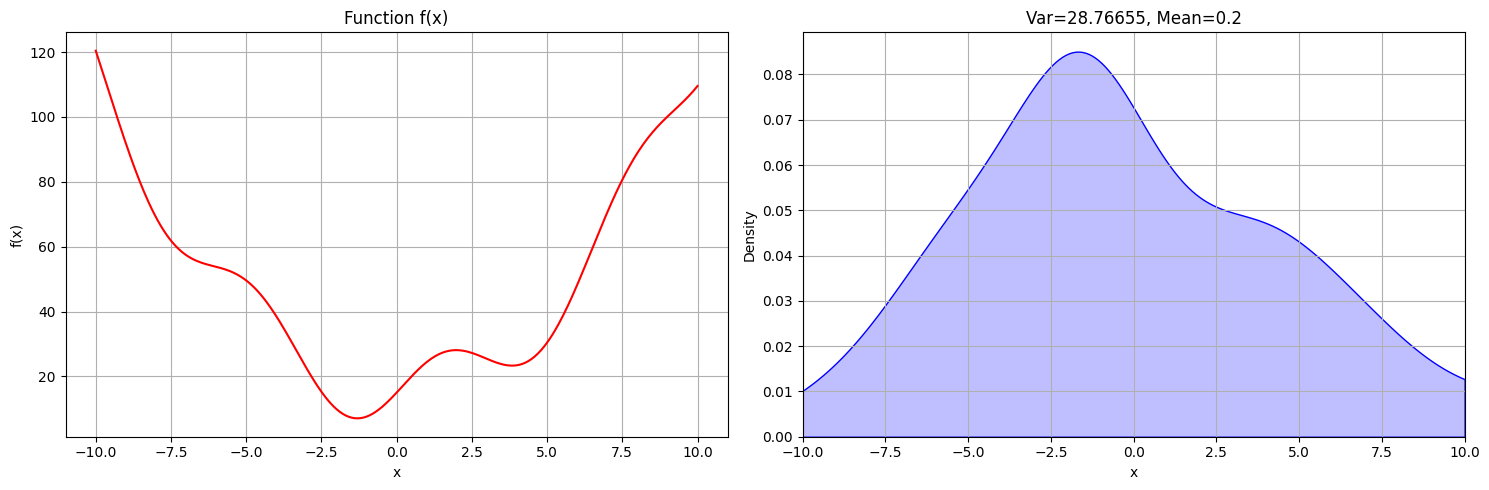

In [8]:
#| echo: false
#| label: fig-PDF-neighbour
#| fig-cap: "Probability density function for the 'neighbour' approach"
x_values_random, y_values_random = algorithm_c(f, 10000, np.random.uniform(-20, 20), 0.8)

# Create a figure with two subplots
fig, axs = plt.subplots(1,2, figsize=(15,5))

# Plot the function on the first subplot
x = np.linspace(-10, 10, 400)
y = f(x)
axs[0].plot(x, y, 'r', label='Function f(x)')
axs[0].set_title('Function f(x)')
axs[0].set_xlabel('x')
axs[0].set_ylabel('f(x)')
axs[1].set_xlim([-10, 10])
axs[0].grid(True)

# Plot the PDF of the search process on the second subplot
sns.kdeplot(x_values_random, ax=axs[1], clip=[-10, 10], fill=True, bw_method=0.3, color='blue', label='PDF of x values')
axs[1].set_title(f'Var={np.var(x_values_random):.5f}, Mean={np.mean(x_values_random):.1f}')
axs[1].set_xlabel('x')
axs[1].set_ylabel('Density')
axs[1].grid(True)
axs[1].set_xlim([-10, 10])

# Adjust the layout
plt.tight_layout()
plt.show()

As you can see, the probability that the algorithm yields the correct solution is a lot higher than for any other value. But it's still not guaranteed, and a lot of the time it returns wrong answers. The variance is still too high. Ideally, we'd always want the highest point of the probability density function to be returned as our solution and ignore all the other values. However, we can't just set the probability of accepting a worse solution to 0 because this would lead to the local optimum quite often. Once we're in the local optimum and don't accept "worse" solutions anymore, there'd be no way out. So we have to find another approach to lead us to the global optimum.

How can we solve this? Instead of immediately setting the acceptance probability for worse states to 0%, we could start at 100% and gradually decrease it. Every time we decrease the probability, we become a little more deterministic and in that way we reject bad solutions more often gradually: At first, we reject the ridiculous solutions, like configurations of a Rubik's cube that are completely mixed. After that, we lower the threshold of good solutions even further, so of all the not-so-bad solutions, we accept only the better ones.

We can imagine this process like filtering out the best solution gradually. The state space for the Rubik's cube could be represented in the following image. At a high acceptance-probability, we do the rough work, filtering out all the terrible configurations, resulting in a better subset of configurations. After that, we refine our search, filtering out the even better solutions from our previous subset. We refine this process even further until we arrive at a 0% acceptance probability for worse solutions, at which point we just pick the perfect fit.

![Filtering step by step. Each rectangle represents a step in the filtering process which is getting refined gradually. The filtering continues until only the solution state remains.](./step-search.png)

This process works like a sieve: at each step we increase the quality and build upon our previous work. If decrease the granularity too fast, bad results will occur, but if we do it carefully enough, we're almost guaranteed to find the solution given enough time. If we were to keep the temperature fixed at a low value, we'd have countless hit-or-miss results because we focus in on one particular configuration, but we're lacking the filtering of all the bad configurations before. If we kept it fixed at a high level, we'd lack the refinement filtering, meaning that we come up with suboptimal solutions that could be improved a lot, but we stopped before.

From now on, we'll call this probability "Temperature" because that's the term used in the simulated annealing algorithm. In our code, it's written as `t`:

In [9]:
def algorithm_d(f, iterations, initial_x):
    x_values = [initial_x]
    y_values = [f(initial_x)]
    t_values = [1] # <1>

    for k in range(iterations):
        current_x, current_y = x_values[-1], y_values[-1]
        new_x = current_x + random.uniform(-1, 1)
        new_y = f(new_x)
        if new_y < current_y or random.random() < t_values[-1]: # <2>
            x_values.append(new_x)
            y_values.append(new_y)

        t_values.append(1 - k / iterations) # <3>

    return x_values, y_values, t_values

1. We start with a temperature of 1 (100% acceptance probability)
2. This change means the same as in our previous algorithms. Because we save the temperatures in an array (for visualization), we want to consider the latest entry.
3. We decrease the temperature linearly

The results of this algorithm look as follows:

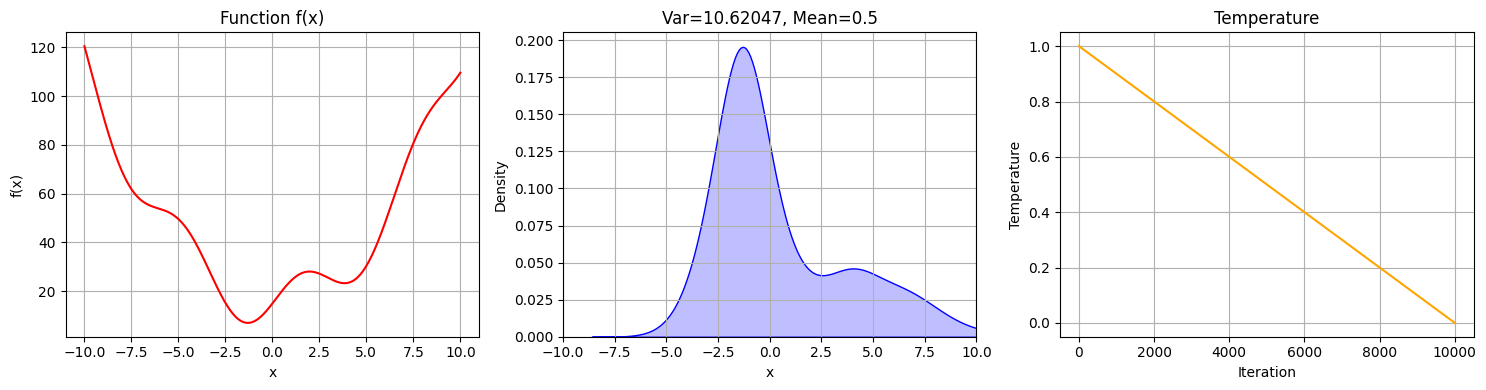

In [10]:
#| echo: false
#| label: fig-PDF-temperature
#| fig-cap: "Probability density function for the 'falling-temperature' approach"
x_values_random, y_values_random, temperature = algorithm_d(f, 10000, np.random.uniform(-20, 20))

# Create a figure with two subplots
fig, axs = plt.subplots(1,3, figsize=(15,4))

# Plot the function on the first subplot
x = np.linspace(-10, 10, 400)
y = f(x)
axs[0].plot(x, y, 'r', label='Function f(x)')
axs[0].set_title('Function f(x)')
axs[0].set_xlabel('x')
axs[0].set_ylabel('f(x)')
axs[0].grid(True)

# Plot the PDF of the search process on the second subplot
sns.kdeplot(x_values_random, ax=axs[1], clip=[-10, 10], fill=True, bw_method=0.3, color='blue', label='PDF of x values')
axs[1].set_title(f'Var={np.var(x_values_random):.5f}, Mean={np.mean(x_values_random):.1f}')
axs[1].set_xlabel('x')
axs[1].set_ylabel('Density')
axs[1].grid(True)
axs[1].set_xlim([-10, 10])

axs[2].plot(range(len(temperature)), temperature, label='Temperature', color='orange')
axs[2].set_title('Temperature')
axs[2].set_xlabel('Iteration')
axs[2].set_ylabel('Temperature')
axs[2].grid(True)

# Adjust the layout
plt.tight_layout()
plt.show()

We can compare this to the solutions for different temperatures from `algorithm_c` in @sec-c with different fixed temperatures:

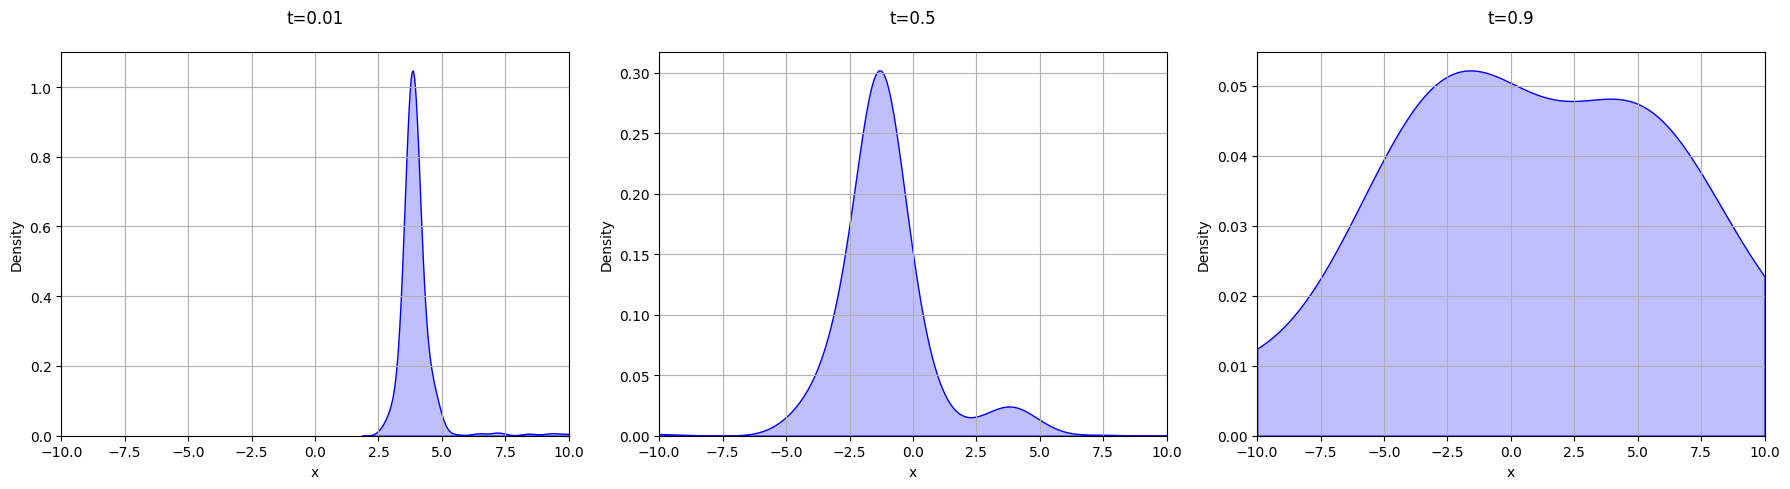

In [11]:
#| echo: false
#| label: fig-PDF-temperature-variations
#| fig-cap: "Probability density function for the results of the 'neighbors' approach with different fixed temperatures"
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# Assuming f is defined somewhere and algorithm_c is a function that takes p as a parameter
# and returns x_values and y_values accordingly.

# Create a figure with three subplots
fig, axs = plt.subplots(1, 3, figsize=(18,5))  # Adjust the figsize if necessary

# Values of p to use
p_values = [0.01, 0.5, 0.9]

# Plot the function on all subplots and the PDF of the search process for each value of p
x = np.linspace(-10, 10, 400)
y = f(x)
for i, p in enumerate(p_values):
    x_values_random, y_values_random = algorithm_c(f, 10000, np.random.uniform(-20, 20), p)

    sns.kdeplot(x_values_random, ax=axs[i], clip=[-10, 10], fill=True, bw_method=0.3, color='blue', label='PDF of x values')
    axs[i].set_title(f't={p}\n')
    axs[i].set_xlabel('x')
    axs[i].set_ylabel('Density')
    axs[i].grid(True)
    axs[i].set_xlim([-10, 10])

# Adjust the layout
plt.tight_layout()
plt.show()


Looking at this new PDF, we can notice a couple of things:

1. The results in @fig-pdf-temperature are more reliable than the PDF with a fixed low temperature (0.01)
2. The results in @fig-pdf-temperature are more concrete than the PDF with fixed high temperature (0.9)

Our results are more reliable because we consider a wider array of possibilities than when starting with a really low acceptance probability, which would immediately focus in on a small section of the graph. Using `algorithm_c` with `t=0.01` will lead to the global minimum quite often. But it's also more concrete than the results we get from using a fixed high temperature. This is because once we reach a low temperature, we focus in on the details, refining our solution.

In [12]:
#| echo: false
x_values_random, y_values_random, temperature = algorithm_d(f, 10000, np.random.uniform(-20, 20))

# Creating a directory to save the frames
if not os.path.exists('frames'):
    os.makedirs('frames')

# Creating the frames
for i in range(11):
    fig, ax = plt.subplots(figsize=(10,8))
    
    # Plot the PDFs at different intervals (10%, 20%, ... 100%)
    chunk_end = int(i * 0.1 * len(x_values_random))
    x_chunk = x_values_random[:chunk_end]
    sns.kdeplot(x_chunk, ax=ax, clip=[-10, 10], fill=True, bw_method=0.3, color='blue', label=f'PDF up to {i*10}%')
    ax.set_title(f'{i*10}%')
    ax.set_xlabel('x')
    ax.set_ylabel('Density')
    ax.grid(True)
    ax.set_xlim([-10, 10])
    ax.set_ylim([0, 0.2])
    
    plt.tight_layout()
    plt.savefig(f'frames/frame_{i:02d}.png')
    plt.close()

frames = [imageio.imread(f'frames/frame_{i:02d}.png') for i in range(11)]
imageio.mimsave('output.gif', frames, duration=0, loop=0)  # 1 frame per second, infinite loop

We can also take a look at how the results from our new algorithm develop over time. The following animation shows the PDF of the values picked by the algorithm in an interval of 10%. As expected, they start out very broad and incorrect, but over time it becomes more narrow and correct.

![Probability density function over time for a fractions of timesteps 'falling-temperature-fractions'](./output.gif)

### Entropy

All the strategies we adapted so far lead to some good results. However, dropping the acceptance probability linearly is a simplification and is rarely the case in reality. You could think about what it's like writing an essay: The outline probably takes less time than all the revisions and details. This is also known as the Pareto Rule (or 80-20 principle) and it shows that to be optimal, we need a more accurate approach for lowering the acceptance probability.

To solve this, we could come up with different temperature schedules, like a geometric decay. However, this doesn't address the underlying problem and may only work for some cases.

Let's think about what the acceptance probability is supposed to do: It should tell us how likely the state that we're observing is getting us closer to the solution. And the solution in our case is the most likely outcome, as we can see in @{fig-pdf-temperature}. The thing we really want to know to be optimal is, how likely is it that our system is in the state that we're observing? So if we know how likely a state is, then we know how good, that is how close to the solution it is.

#### Boltzmann distribution

The Boltzmann distribution gives us exactly that: it is a probability distribution that gives the probability that a system will be in a certain state as a function of that state's energy and the temperature of the system^[Source: [Wikipedia](https://en.wikipedia.org/wiki/Boltzmann_distribution)]. It is defined as:

$$
p_i \propto e^{- \frac{\varepsilon_i}{kT}}
$$

- $\varepsilon_i$: Energy at a specific state $i$
    - in our example "energy" = "cost" = y-value
- $T$: Temperature
- $k$: Boltzmann constant, can be ignored and assumed to be $1$

#### Boltzman factor

This is the entire distribution and ultimately, what we're interested in. To calculate it, we use the  Boltzmann factor, which is defined as:

$$
e^{-\frac{\Delta E}{T}}
$$

- $\Delta E$: Difference in energy between two states
    - $\Delta E =$ `new_y` - `current_y` in our code
 
So all we have to do now is plugging in the temperature and cost into the equation for the Boltzmann factor and use it as the acceptance probability when evaluating the states. This gives us the simulated annealing algorithm.

In [13]:
def simulated_annealing(f, iterations, initial_x):
    x_values = [initial_x]
    y_values = [f(initial_x)]
    t_values = [1]

    for k in range(iterations):
        current_x, current_y = x_values[-1], y_values[-1]
        new_x = current_x + random.uniform(-1, 1)
        new_y = f(new_x)
        
        delta_e = new_y - current_y
        p = exp(-(delta_e)/t_values[-1]) # <1>
        
        p_values.append(p)
        if delta_e < 0 or random.random() < p: # <2>
            x_values.append(new_x)
            y_values.append(new_y)

        t_values.append(1 - k / iterations)

    return x_values, y_values, t_values

1. The Boltzmann factor, which is our acceptance probability for states that are worse than the current one
2. We still always accept better states without asking, in the other cases we do so based on the Boltzmann factor. Together, this is called the "Metropolis acceptance criterion"

Running simulated annealing with our example problem yields the following result:

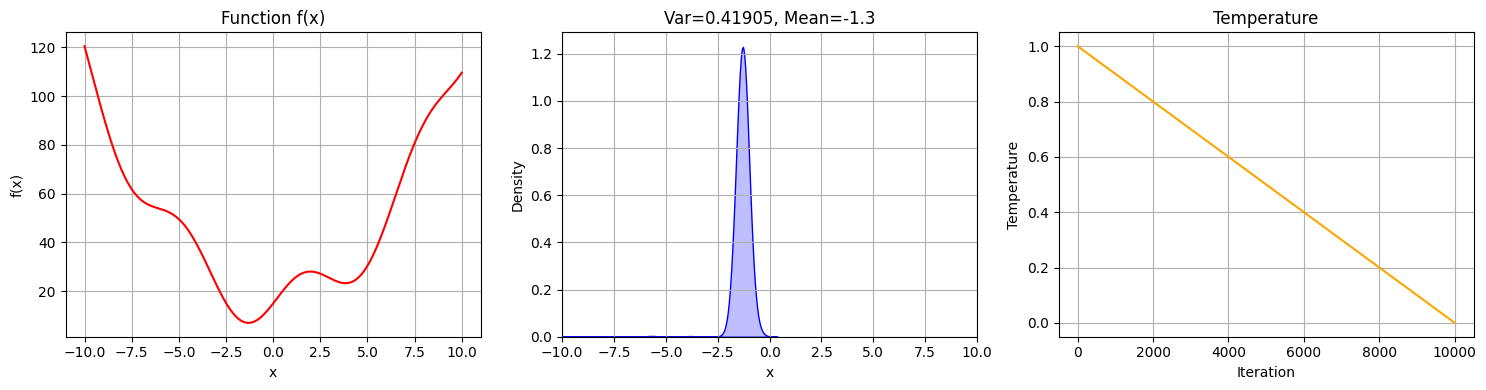

In [14]:
#| echo: false
#| label: fig-PDF-annealing
#| fig-cap: "Probability density function for the 'simulated annealing' algorithm"
x_values_random, y_values_random, temperature = simulated_annealing(f, 10000, np.random.uniform(-20, 20))

# Create a figure with two subplots
fig, axs = plt.subplots(1,3, figsize=(15,4))

# Plot the function on the first subplot
x = np.linspace(-10, 10, 400)
y = f(x)
axs[0].plot(x, y, 'r', label='Function f(x)')
axs[0].set_title('Function f(x)')
axs[0].set_xlabel('x')
axs[0].set_ylabel('f(x)')
axs[0].grid(True)

# Plot the PDF of the search process on the second subplot
sns.kdeplot(x_values_random, ax=axs[1], clip=[-10, 10], fill=True, bw_method=0.3, color='blue', label='PDF of x values')
axs[1].set_title(f'Var={np.var(x_values_random):.5f}, Mean={np.mean(x_values_random):.1f}')
axs[1].set_xlabel('x')
axs[1].set_ylabel('Density')
axs[1].grid(True)
axs[1].set_xlim([-10, 10])

axs[2].plot(range(len(temperature)), temperature, label='Temperature', color='orange')
axs[2].set_title('Temperature')
axs[2].set_xlabel('Iteration')
axs[2].set_ylabel('Temperature')
axs[2].grid(True)

# Adjust the layout
plt.tight_layout()
plt.show()

The probability of finding the solution with this approach is very high. It's almost guaranteed now. By tuning the temperature schedule and running more iterations, these results would become even more apparent. We have therefore found a great solution to the problem.

## Summary

Leveraging the concepts discussed in this article, simulated annealing can be used not only to find solutions to simple problems as with our function $f(x)$, but for *any* search problem, no matter how complex. As long as there's a cost function and a temperature schedule, simulated annealing is guaranteed to find the optimal solution, given enough time and a temperature schedule that decreases slowly enough.

The concepts in this article have even more depth to them. For example, one could ask: why is the Boltzmann distribution defined the way it is? Or how could one find the optimal temperature for the algorithm? All these are questions that deserve their own time to discuss. This article should just give a well reasoned intuition of why it works at all.